# Word Similarity with BERT

*This notebook draws upon materials created by the [The BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team*

In Lucy Li's [paper about language variation across Reddit communities](https://arxiv.org/abs/2102.06820), she used two methods for determining the community-specific meanings of certain words: comparing the similarity of their BERT embeddings within commmunities, and comparing their potential BERT-dervied substitutes within communities. In the case of the former, the underlying method is a measure of cosine similarity, which is what this notebook will explore, using a collection of 16th-20th century English language poems. 

## Data and model
Our poems were scraped from [Public-Domain-Poetry.com](http://public-domain-poetry.com/) by Melanie Walsh. As for our model, we'll be using the [DistilBert model](https://huggingface.co/transformers/model_doc/distilbert.html) via the HuggingFace Python library. As we discused last class, DistilBert is a smaller — yet still powerful! — version of BERT. By using the rich representations of words that BERT produces, we will then explore the multivalent meanings of particular words in context and over time.

## Overview: Word similarity
Just as Lucy asked whether r/Fitness and r/CasualUK used the word "lift" in different ways, we can ask whether 16th-century and 20th-century poets use the word "science" in different ways. Or the word "nature." Or the word "machine." We'll use cosine similiarity to compare each embedding, since these embeddings are, in fact, vectors! If you recall, we've used this same calculation of cosine similarity to compare TF/IDF representations of documents; and word2vec-derived vectors of words in a corpus.

Since much of the code below setup--that is, loading the poetry dataset, encoding it for use with BERT, and downloading the pretrained DistilBert model, it might help to see a preview of where we're heading:

In [2]:
#@title Similarity with BERT Embeddings: A Preview { display-mode: "form" }
#@title: Hover
import pandas as pd
import altair as alt

url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/bert-word-nature.csv"
df = pd.read_csv(url, encoding='utf-8')

search_keywords = ['nature', 'science', 'religion', 'art']
color_by = 'word'

alt.Chart(df, title=f"Word Similarity: {', '.join(search_keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

The plot above displays a preview of our similarity analysis. This is what we're working toward!

You can hover over each point to see the instance of each word in context. If you press `Shift` and click on a point, you will be taken to the original poem on Public-Domain-Poetry.com. Try it out!

## **Import necessary Python libraries and modules**

Ok enough introduction! Let's get started.

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we first need to install it with `pip`.

In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 44.0 MB/s 
     |████████████████████████████████| 895 kB 47.7 MB/s 
     |████████████████████████████████| 3.3 MB 38.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Then we will import the DistilBertModel and DistilBertTokenizerFast from the Hugging Face `transformers` library. We will also import a handful of other Python libraries and modules.

In [2]:
# For BERT
from transformers import DistilBertTokenizerFast, DistilBertModel

# For data manipulation and analysis
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np
from sklearn.decomposition import PCA

# For interactive data visualization
import altair as alt

## **Load text dataset**

Our dataset contains around ~30 thousand poems scraped from  http://public-domain-poetry.com/. This website hosts a curated collection of poems that have fallen out of copyright, which makes them easier for us to share on the web. 
You can find the data in Melanie Walsh's [GitHub repository](https://github.com/melaniewalsh/BERT-4-Humanists/blob/main/data/public-domain-poetry.csv).

We don't have granular date information about when each poem was published, but we do know the birth dates of most of our authors, which we've used to loosely categorize the poems by time period. The poems in our data range from the Middle Ages to the 20th Century, but most come from the 19th Century. The data features both well-known authors — William Wordsworth, Emily Elizabeth Dickinson, Paul Laurence Dunbar, Walt Whitman, Shakespeare — as well as less well-known authors.

In what follows, we'll use `pandas` to read in our CSV file of poems. It is convenient (especially for Colab notebooks) that `pandas` allows you to read in files directly from the web. If you end up using Colab for your final project, you may want to borrow this GitHub->Colab pipeline for storing and importing your data.

In [3]:
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"

poetry_df = pd.read_csv(url, encoding='utf-8')
# Show 5 random rows
poetry_df.sample(5)

,author,title,text,lifespan,birth_year,death_year,link,period
4540,D. H. Lawrence (David Herbert Richards),Martyr ' La Mode,"Ah God, life, law, so many names you keep,\r\nYou great, you patient Effort, and you Sleep\r\nThat does inform this various dream of living,\r\nYou sleep stretched out for ever, ever giving\r\nUs ...",11 September 1885-2 March 1930,1885.0,1930.0,http://public-domain-poetry.com/d-h-lawrence/martyr-la-mode-22903,20th Century
12611,John Greenleaf Whittier,The Captain's Well,"From pain and peril, by land and main,\r\nThe shipwrecked sailor came back again;\n\r\nAnd like one from the dead, the threshold cross'd\r\nOf his wondering home, that had mourned him lost.\n\r\nW...","December 17, 1807-September 7, 1892",1807.0,1892.0,http://public-domain-poetry.com/john-greenleaf-whittier/captains-well-6039,19th Century
23861,Thomas Campion,My Sweetest Lesbia,"An imitation of Catallus\n\r\nMy sweetest Lesbia, let us live and love,\r\nAnd though the sager sort our deeds reprove,\r\nLet us not weigh them. Heaven's great lamps do dive\r\nInto their west, a...","February 12, 1567-March 1, 1620",1567.0,1620.0,http://public-domain-poetry.com/thomas-campion/my-sweetest-lesbia-12063,16th-17th Centuries (Early Modern)
28545,William Butler Yeats,Me Peacock,"What's riches to him\r\nThat has made a great peacock\r\nWith the pride of his eye?\r\nThe wind-beaten, stone-grey,\r\nAnd desolate Three Rock\r\nWould nourish his whim.\r\nLive he or die\r\nAmid ...","June 13, 1865-January 28, 1939",1865.0,1939.0,http://public-domain-poetry.com/william-butler-yeats/me-peacock-248,19th Century
5528,Edward Lear,Book Of Nonsense Limerick 109,"There was a Young Lady of Parma,\r\nWhose conduct grew calmer and calmer;\r\nWhen they said, ""Are you dumb?""\r\nShe merely said, ""Hum!""\r\nThat provoking Young Lady of Parma.",12 May 1812-29 January 1888,1812.0,1888.0,http://public-domain-poetry.com/edward-lear/book-of-nonsense-limerick-109-23233,19th Century


In [6]:
#@title *Click here to see how you might load a dataset from your own computer*
#from google.colab import files
#uploaded = files.upload()

Let's check to see how many poems are in this dataset:

In [7]:
len(poetry_df)

31080

Let's check to see which authors show up the most in this dataset to get a sense of its contours:

In [ ]:
poetry_df['author'].value_counts()[:20]

Robert Herrick                   1464
Madison Julius Cawein            1345
William Wordsworth                963
Thomas Moore                      853
Thomas Hardy                      655
Rudyard Kipling                   638
Robert Burns                      499
John Greenleaf Whittier           481
Algernon Charles Swinburne        461
Emily Elizabeth Dickinson         447
Paul Laurence Dunbar              417
John Clare                        382
William Butler Yeats              378
Francesco Petrarca (Petrarch)     375
Paul Cameron Brown                341
Walt Whitman                      338
Edgar Lee Masters                 331
Percy Bysshe Shelley              330
Walter De La Mare                 329
Oliver Wendell Holmes             329
Name: author, dtype: int64

**What potential biases in the dataset can you detect from the value counts above?**

Let's also check to see what time periods show up the most in this dataset to get a sense of its contours:

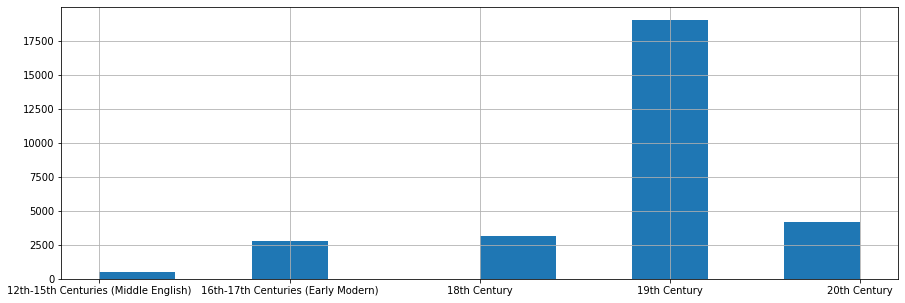

In [8]:
# Sort values, then create a histogram, and define the size of the figure
poetry_df['period'].sort_values().hist(figsize=(15, 5))

## **Sample text dataset**

Though we wish we could analyze all the poems in this data, Colab tends to crash if we try to use more than 4-5,000 poems —  even with DistilBert, the smaller version of BERT. This is an important limitation to keep in mind. If you'd like to use more text data, please get in touch with me so that I can set you up on the QTM cluster.

For our purposes today, to reduce the number of poems into a managable amount, we will take a random sample of 1,000 poems from four different time periods: the 20th Century, 19th Century, 18th Century, and the Early Modern period.

In [4]:
# Filter the DataFrame for only a given time period, then randomly sample 1000 rows
nineteenth_sample = poetry_df[poetry_df['period'] == '19th Century'].sample(1000)
twentieth_sample = poetry_df[poetry_df['period'] == '20th Century'].sample(1000)
eighteenth_sample = poetry_df[poetry_df['period'] == '18th Century'].sample(1000)
sixteenth_sample = poetry_df[poetry_df['period'] == '16th-17th Centuries (Early Modern)'].sample(1000)

In [5]:
# Merge these random samples into a new DataFrame
poetry_df = pd.concat([sixteenth_sample, eighteenth_sample, twentieth_sample, nineteenth_sample])

In [6]:
poetry_df['period'].value_counts()

19th Century                          1000
18th Century                          1000
16th-17th Centuries (Early Modern)    1000
20th Century                          1000
Name: period, dtype: int64

Finally, let's make a list of poems from our Pandas DataFrame.

In [7]:
poetry_texts = poetry_df['text'].tolist()

Let's examine a poem in our dataset:

In [13]:
len(poetry_texts)

4000

In [8]:
print(poetry_texts[0])

What's in the brain, that ink may character,
Which hath not figur'd to thee my true spirit?
What's new to speak, what now to register,
That may express my love, or thy dear merit?
Nothing, sweet boy; but yet, like prayers divine,
I must each day say o'er the very same;
Counting no old thing old, thou mine, I thine,
Even as when first I hallow'd thy fair name.
So that eternal love in love's fresh case,
Weighs not the dust and injury of age,
Nor gives to necessary wrinkles place,
But makes antiquity for aye his page;
Finding the first conceit of love there bred,
Where time and outward form would show it dead.


## **Encode/tokenize text data for BERT**

Next we need to *encode* (or *tokenize*) our poems into the format that BERT (via Huggingface) will understand. We did this last class as well. 

As before, we'll tokenize the poems with the `tokenizer()` from HuggingFace's `DistilBertTokenizerFast`. Recall what the `tokenizer()` will do:

1. Truncate the texts if they're more than 512 tokens or pad them if they're fewer than 512 tokens. If a word is not in BERT's vocabulary, it will be broken up into smaller "word pieces," demarcated by a `##`.

2. Add in special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence 
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece" 

Here we will load `DistilBertTokenizerFast` from HuggingFace library, which will help us transform and encode the texts so they can be used with BERT.

In [9]:
from transformers import DistilBertTokenizerFast

In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [11]:
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

Let's examine the first tokenized poem. We can see that the special BERT tokens have been inserted where necessary.

In [12]:
' '.join(tokenized_poems[0].tokens)

"[CLS] what ' s in the brain , that ink may character , which hat ##h not fig ##ur ' d to thee my true spirit ? what ' s new to speak , what now to register , that may express my love , or thy dear merit ? nothing , sweet boy ; but yet , like prayers divine , i must each day say o ' er the very same ; counting no old thing old , thou mine , i thin ##e , even as when first i hall ##ow ' d thy fair name . so that eternal love in love ' s fresh case , weighs not the dust and injury of age , nor gives to necessary wr ##inkles place , but makes antiquity for aye his page ; finding the first con ##ce ##it of love there bred , where time and outward form would show it dead . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

<br><br>

## **Load pre-trained BERT model**

Here we will load a pre-trained BERT model. To speed things up we will use a GPU, but using GPU involves a few extra steps.
The command `.to("cuda")` moves data from regular memory to the GPU's memory.




In [13]:
from transformers import DistilBertModel

In [14]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **Get BERT word embeddings for each document in a collection**

To get word embeddings for all the words in our collection, we will use a basic `for` loop.

The process is as follows: for each poem in our list `poetry_texts`, we will tokenize the poem, and we will extract the vocabulary word ID for each word/token in the poem (to use for later reference). Then we will run the tokenized poem through the BERT model and extract the vectors for each word/token in the poem.

We thus create two big lists for all the poems in our collection — `doc_word_ids` and `doc_word_vectors`.

In [15]:
# List of vocabulary word IDs for all the words in each document (aka each poem)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each poem)
doc_word_vectors = []

# Below we will slice our poem to ignore the first (0th) and last (-1) special BERT tokens
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one poem at a time
first_document = 0

for i, poem in enumerate(poetry_texts):
  
    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(poem, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to("cuda")
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd to last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())


Confirm that we have the same number of documents for both the tokens and the vectors:

In [22]:
len(doc_word_ids), len(doc_word_vectors)

(4000, 4000)

In [16]:
doc_word_ids[0], doc_word_vectors[0]

(array([ 2054,  1005,  1055,  1999,  1996,  4167,  1010,  2008, 10710,
         2089,  2839,  1010,  2029,  6045,  2232,  2025, 20965,  3126,
         1005,  1040,  2000, 14992,  2026,  2995,  4382,  1029,  2054,
         1005,  1055,  2047,  2000,  3713,  1010,  2054,  2085,  2000,
         4236,  1010,  2008,  2089,  4671,  2026,  2293,  1010,  2030,
        15177,  6203,  7857,  1029,  2498,  1010,  4086,  2879,  1025,
         2021,  2664,  1010,  2066, 12583,  7746,  1010,  1045,  2442,
         2169,  2154,  2360,  1051,  1005,  9413,  1996,  2200,  2168,
         1025, 10320,  2053,  2214,  2518,  2214,  1010, 15223,  3067,
         1010,  1045,  4857,  2063,  1010,  2130,  2004,  2043,  2034,
         1045,  2534,  5004,  1005,  1040, 15177,  4189,  2171,  1012,
         2061,  2008, 10721,  2293,  1999,  2293,  1005,  1055,  4840,
         2553,  1010, 21094,  2025,  1996,  6497,  1998,  4544,  1997,
         2287,  1010,  4496,  3957,  2000,  4072, 23277, 28562,  2173,
      

In [19]:
# Take a look at the number of vectors for one of the words
len(doc_word_vectors[0])

156

## **Concatenate all word IDs/vectors for all documents**

Each element of these lists contains all the tokens/vectors for one document. But we want to concatenate them into two giant collections for ease of use.

In [21]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

## **Computing Cosine Similarity**

Here's where we compute the *cosine similarity* of the vectors. Because cosine similarity measures the angle between vectors but ignores their length, we can speed this computation up by setting all the poem vectors to have length 1.0.

In [22]:
# Calculating the length of each vector (Pythagorean theorem)
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
# Dividing every vector by its length
all_word_vectors /= row_norms[:,np.newaxis]

Now that we've normalized our vectors so that each has a length of 1, we can calculate the cosine similiarity between one vector and any other (or set of others) by taking the dot product of the two vectors. Here's a function we can write to do that: 


In [38]:
def get_nearest(query_vector, n=20):
  cosines = all_word_vectors.dot(query_vector)
  ordering = np.flip(np.argsort(cosines))
  return ordering[:n]

But, to make any results legible to humans, we need to be able to reattach these vectors to the words and contexts that they represent. Here are a bunch of functions that can help us do that:

## **Helpful functions** 

**Find all word positions in a collection**

This function uses the array `all_word_ids` to find all the places, or *positions*, in the collection where a word appears.

We'll do this with the `tokenizer.vocab` attribute, finding the word's vocab ID in BERT and then checking to see where/how many times this ID occurs in `all_word_ids`.

In [24]:
def get_word_positions(words):
  
  """This function accepts a list of words, rather than a single word"""

  # Get word/vocabulary ID from BERT for each word
  word_ids = [tokenizer.vocab[word] for word in words]

  # Find all the positions where the words occur in the collection
  word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

  return word_positions

For example, we can check to see all the places where the word "bank" appears in the collection.

In [25]:
get_word_positions(["bank"])

array([ 85052,  99739, 103656, 125786, 163794, 167952, 171197, 184134,
       207733, 214060, 281766, 312442, 325683, 335463, 337324, 347816,
       362681, 362683, 387765, 391178, 408843, 428894, 452025, 464523,
       466760, 466763, 523847, 525831, 554701, 564594, 564783, 614449,
       646787, 668748, 787816, 801487, 922892, 937543, 937663, 937703,
       940779])

**Use get_word_positions to find word from word position**

The above function allow us to determine all the positions where the word "bank" appears in the collection. But it would be more helpful to us as humans to know the actual words that appear in context around it. To find these context words, we have to convert position IDs back into words, like so:

In [27]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

Now we can use `word_lookup` to find a word based on its position in the collection. Let's first see what the output of a basic lookup operation looks like.

In [28]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:
  print(word_position, word_lookup[all_word_ids[word_position]])

85052 bank
99739 bank
103656 bank
125786 bank
163794 bank
167952 bank
171197 bank
184134 bank
207733 bank
214060 bank
281766 bank
312442 bank
325683 bank
335463 bank
337324 bank
347816 bank
362681 bank
362683 bank
387765 bank
391178 bank
408843 bank
428894 bank
452025 bank
464523 bank
466760 bank
466763 bank
523847 bank
525831 bank
554701 bank
564594 bank
564783 bank
614449 bank
646787 bank
668748 bank
787816 bank
801487 bank
922892 bank
937543 bank
937663 bank
937703 bank
940779 bank


But we're not done yet. We can modify the above code to look for the 3 words that come before "bank" and the 3 words that come after it.

In [29]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

  # Slice 3 words before "bank"
  start_pos = word_position - 3
  # Slice 3 words after "bank"
  end_pos = word_position + 4

  context_words = word_lookup[all_word_ids[start_pos:end_pos]]
  # Join the words together
  context_words = ' '.join(context_words)
  print(word_position, context_words)

85052 red ##eem a bank of moss ,
99739 a sunni ##e bank ##e outstretched lay
103656 self ##e a bank ##rou ##t know
125786 vp ##pon a bank with roses set
163794 hedge , and bank , and stil
167952 stood upon a bank , above her
171197 , on some bank beside a river
184134 the gravel ##ly bank thrown up by
207733 ##ied a western bank ' s still
214060 ##no ' s bank , and on
281766 from this steep bank to follow '
312442 er yo ##n bank and o '
325683 i . now bank an ' bra
335463 pri ##m ##rose bank , her throne
337324 sees but the bank that from thee
347816 bright gem every bank and trembling leaf
362681 , shooting from bank to bank ,
362683 from bank to bank , now in
387765 the dew ##y bank to grace !
391178 ##ted in a bank an ' clark
408843 " see this bank - note -
428894 thames ' s bank , a young
452025 fishing on the bank - side .
464523 . . the bank default ##er lee
466760 , from , bank to low bank
466763 bank to low bank of the river
523847 the loft ##y bank , and level
525831 the brigh

Now that we've tested out this approach, let's make some functions that will help us get the context words around a certain word position for whatever size window (certain number of words before and after) that we want.

The first function `get_context()` will simply return the tokens without cleaning them, and the second function `get_context_clean()` will return the tokens in a more readable fashion. (Note the return of regex!) 

In [30]:
def get_context(word_id, window_size=10):
  
  """Simply get the tokens that occur before and after word position"""

  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  context_words = " ".join(tokens)

  return context_words

In [31]:
import re

def get_context_clean(word_id, window_size=10):
  
  """Get the tokens that occur before and after word position AND make them more readable"""

  keyword = word_lookup[all_word_ids[word_id]]
  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  # Make wordpieces slightly more readable
  # This is probably not the most efficient way to clean and correct for weird spacing
  context_words = " ".join(tokens)
  context_words = re.sub(r'\s+([##])', r'\1', context_words)
  context_words = re.sub(r'##', r'', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)
  context_words = re.sub('\s\'er', '\'er', context_words)
  context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
  context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)

  # Bold the keyword by putting asterisks around it
  if keyword in context_words:
    context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
    context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

  return context_words

## **Examining most similar vectors**

At long last, we're ready to perform our similarity comparison. First we need to decide which particular instance of "bank" we want to examine. Let's print out some instances of "bank" in our poetry corpus to see if one seems interesting to us. 



In [33]:
# load some libraries for displaying text nicely
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))

In [36]:
# print out instances of "bank" in the corpus
word_positions = get_word_positions(['bank'])

for word_position in word_positions:

  print_md(f"<br> {word_position}: {get_context_clean(word_position)} <br>")

<br> 85052: and many a cross-track they redeem a **bank** of moss, spongy and swelling, and <br>

<br> 99739: shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might <br>

<br> 103656: , and by iust counts my selfe a bankrout know of all those goods which heau <br>

<br> 125786: and slave it in an hour. vppon a **bank** with roses set about, where pretty turtles ioyn <br>

<br> 163794: waves efface pathway, and hedge, and **bank**, and stile!-i find but one <br>

<br> 167952: a pheasant, as she stood upon a **bank**, above her brood; with pride maternal beat her <br>

<br> 171197: , and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies <br>

<br> 184134: washed by the sea, or on the gravelly **bank** thrown up by wintry torrents roaring loud, <br>

<br> 207733: . distant a little mile he spied a western **bank**'s still sunny side, and right toward the <br>

<br> 214060: 's golden store, on arno's **bank**, and on that bloomy shore, warbling <br>

<br> 281766: tell you truth. a lamb leapt from this steep **bank** to follow 'cross the brook its thoughtless dam <br>

<br> 312442: dearie. ii. o 'er yon **bank** and o 'er yon brae, o <br>

<br> 325683: find the honey on his tongue. i. now **bank** an 'brae are claith'd in <br>

<br> 335463: under her dominion placed. upon a primrose **bank**, her throne of quietness, she sits alone <br>

<br> 337324: deride that shortsighted one sees but the **bank** that from thee is flying, not the one which <br>

<br> 347816: thou seen a vernal morning bright gem every **bank** and trembling leaf with dews, tinging the <br>

<br> 362681: still water, with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift <br>

<br> 362683: , with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift athwa <br>

<br> 387765: his small green lamp at night, the dewy **bank** to grace! it is a glow-worm, <br>

<br> 391178: led a market, or strutted in a **bank** an 'clarkit my cash-account: while <br>

<br> 408843: , a senator addressing, said: "see this **bank**-note-lo! a blessing-breathe on <br>

<br> 428894: friendly breast cecilia liv'd on thames's **bank**, a young and lovely married fair; to creatures <br>

<br> 452025: ns and great birds watch and go fishing on the **bank**-side. no man dare go alone in the <br>

<br> 464523: the watchman climbs the stair... the **bank** defaulter leers at a chaos of figures, <br>

<br> 466760: 's cry, wild or grave, from, **bank** to low **bank** of the river rings; but the <br>

<br> 466763: , wild or grave, from, **bank** to low **bank** of the river rings; but the uncertain river though <br>

<br> 523847: spot, in years gone by. the lofty **bank**, and level plain, with wide-mouth ' <br>

<br> 525831: fleeting quarters and the hours, while the bright clouds **banked** eastward back of them blush in the sunset, <br>

<br> 554701: oon of wood-doves sounds and moss-**banked** water flows, or musing late till the <br>

<br> 564594: frozen ratlines shrieking in the gale upon a **bank**, easeless with knobs of gold, beneath <br>

<br> 564783: hidden enemy must lurk within the clouds above that **bank**, it strained so wildly its pale, stubborn eye <br>

<br> 614449: she turned her home with cod from george's **bank** when winds were blowing. and i know from that <br>

<br> 646787: belliferous flowers, and the yellow clay of its **bank**, the barge's brown sails that are fur <br>

<br> 668748: gave me both her hands. stretched on a sunny **bank** he lay at rest, ferns at his elbow, <br>

<br> 787816: y cistus, blooming wet, blushed on **bank** and bowlder; there the cyclamen, <br>

<br> 801487: coming storm, we camped a furlong from the **bank**. our jack, the little man that used to <br>

<br> 922892: i take your money, i put it in your **bank**, and live sumptuously on the interest. <br>

<br> 937543: he'd hold her nozzle agin the **bank** till the last soul got ashore. all boats has <br>

<br> 937663: she turned, and made for that willer-**bank** on the right. there was runnin 'and <br>

<br> 937703: i 'll hold her nozzle agin the **bank** till the last galoot's ashore. " <br>

<br> 940779: spent swimmer's eyes, until upon the sloping **bank** he stand, mute in the light of eden- <br>

Now we can pick any of these keyword positions to compare to.

In [37]:
keyword_position = 940779 # can be replaced with any of the above

And at long last, display the most similar vectors

In [39]:
contexts = [get_context_clean(token_id) for token_id in get_nearest(all_word_vectors[keyword_position,:])]

for context in contexts:
  print_md(context)

spent swimmer's eyes, until upon the sloping **bank** he stand, mute in the light of eden-

spot, in years gone by. the lofty **bank**, and level plain, with wide-mouth '

washed by the sea, or on the gravelly **bank** thrown up by wintry torrents roaring loud,

frozen ratlines shrieking in the gale upon a **bank**, easeless with knobs of gold, beneath

coming storm, we camped a furlong from the **bank**. our jack, the little man that used to

hidden enemy must lurk within the clouds above that **bank**, it strained so wildly its pale, stubborn eye

, wild or grave, from, **bank** to low **bank** of the river rings; but the uncertain river though

a pheasant, as she stood upon a **bank**, above her brood; with pride maternal beat her

, and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies

friendly breast cecilia liv'd on thames's **bank**, a young and lovely married fair; to creatures

tell you truth. a lamb leapt from this steep **bank** to follow 'cross the brook its thoughtless dam

gave me both her hands. stretched on a sunny **bank** he lay at rest, ferns at his elbow,

's cry, wild or grave, from, **bank** to low **bank** of the river rings; but the

i 'll hold her nozzle agin the **bank** till the last galoot's ashore. "

under her dominion placed. upon a primrose **bank**, her throne of quietness, she sits alone

he'd hold her nozzle agin the **bank** till the last soul got ashore. all boats has

belliferous flowers, and the yellow clay of its **bank**, the barge's brown sails that are fur

ns and great birds watch and go fishing on the **bank**-side. no man dare go alone in the

the flowery margin of the stream, along the **banks** the clear song would he hear, and pipe of

she turned, and made for that willer-**bank** on the right. there was runnin 'and

## **Reduce word vectors via PCA and plot them**

We don't need to just *read* examples of similar usages of "bank" in the collection, we can also visualize them. 

But to do so, we need to perform some dimensionality reduction. Previously, we've used t-SNE for this purpose. Here, for variety's sake, we will use PCA. 

In [40]:
from sklearn.decomposition import PCA

word_positions = get_word_positions(["bank"])

pca = PCA(n_components=2)

pca.fit(all_word_vectors[word_positions,:].T)

PCA(n_components=2)

Let's now make a list of all of the context views for our keyword so that we can associate them with their PCA score:

In [43]:
word_positions = get_word_positions(["bank"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:

  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

Then, for convenience, we will put these PCA results into a Pandas DataFrame, which will use to generate an interactive plot.

In [44]:
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df.head()

,x,y,context,tokens
0,-0.148609,-0.113298,"and many a cross-track they redeem a **bank** of moss, spongy and swelling, and","and many a cross - track they red ##eem a bank of moss , sp ##ong ##y and swelling , and"
1,-0.150959,-0.101768,"shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might","shore of mud ##die nile , upon a sunni ##e bank ##e outstretched lay , in monstrous length , a might"
2,-0.148763,-0.384854,", and by iust counts my selfe a bankrout know of all those goods which heau",", and by i ##ust counts my self ##e a bank ##rou ##t know of all those goods which he ##au"
3,-0.164662,-0.060138,"and slave it in an hour. vppon a **bank** with roses set about, where pretty turtles ioyn","and slave it in an hour . vp ##pon a bank with roses set about , where pretty turtles io ##yn"
4,-0.159366,-0.059525,"waves efface pathway, and hedge, and **bank**, and stile!-i find but one","waves e ##ffa ##ce pathway , and hedge , and bank , and stil ##e ! - i find but one"


## **Match context with original text and metadata** 

It's helpful (and fun!) to know where each instance of a word actually comes from — which poem, which poet, which time period, which Public-Domain-Poetry.com web page. The easiest method we've found for matching a bit of context with its original poem and metdata is to 1) add a tokenized version of each poem to our original Pandas Dataframe 2) check to see if the context shows up in a poem 3) and if so, grab the original poem and metadata.

In [45]:
# Tokenize all the poems
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_poems = []
for i in range(len(tokenized_poems['input_ids'])):
  all_tokenized_poems.append(' '.join(tokenized_poems[i].tokens))

# Add them to the original DataFrame
poetry_df['tokens'] = all_tokenized_poems

In [46]:
poetry_df.head(2)

,author,title,text,lifespan,birth_year,death_year,link,period,tokens
29998,William Shakespeare,"The Sonnets CVIII - What's in the brain, that ink may character","What's in the brain, that ink may character,\r\nWhich hath not figur'd to thee my true spirit?\r\nWhat's new to speak, what now to register,\r\nThat may express my love, or thy dear merit?\r\nNoth...",baptised 26 April 1564-23 April 1616,1564.0,1616.0,http://public-domain-poetry.com/william-shakespeare/sonnets-cviii-whats-in-the-brain-that-ink-may-character-8260,16th-17th Centuries (Early Modern),"[CLS] what ' s in the brain , that ink may character , which hat ##h not fig ##ur ' d to thee my true spirit ? what ' s new to speak , what now to register , that may express my love , or thy dear..."
12129,John Dryden,A Song,"Go tell Amynta, gentle swain,\r\nI would not die, nor dare complain:\r\nThy tuneful voice with numbers join,\r\nThy words will more prevail than mine.\r\nTo souls oppress'd and dumb with grief,\r\...",( 9 August 1631-1 May 1700 ),1631.0,1700.0,http://public-domain-poetry.com/john-dryden/song-14657,16th-17th Centuries (Early Modern),"[CLS] go tell amy ##nta , gentle sw ##ain , i would not die , nor dare complain : thy tune ##ful voice with numbers join , thy words will more pre ##va ##il than mine . to souls op ##press ' d and..."


In [47]:
def find_original_poem(rows):

  """This function checks to see whether the context tokens show up in the original poem,
  and if so, returns metadata about the title, author, period, and URL for that poem"""

  text = rows['tokens'].replace('**', '')
  text = text[55:70]

  if poetry_df['tokens'].str.contains(text, regex=False).any() == True :
    row = poetry_df[poetry_df['tokens'].str.contains(text, regex=False)].values[0]
    title, author, period, link = row[0], row[1], row[7], row[6]
    return author, title, period, link
  else:
    return None, None, None, None

In [48]:
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

In [49]:
df

,x,y,context,tokens,title,author,period,link
0,-0.148609,-0.113298,"and many a cross-track they redeem a **bank** of moss, spongy and swelling, and","and many a cross - track they red ##eem a bank of moss , sp ##ong ##y and swelling , and",Oberon's Palace,Robert Herrick,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/robert-herrick/oberons-palace-18864
1,-0.150959,-0.101768,"shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might","shore of mud ##die nile , upon a sunni ##e bank ##e outstretched lay , in monstrous length , a might",Visions Of The Worlds Vanitie,Edmund Spenser,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/edmund-spenser/visions-of-the-worlds-vanitie-32234
2,-0.148763,-0.384854,", and by iust counts my selfe a bankrout know of all those goods which heau",", and by i ##ust counts my self ##e a bank ##rou ##t know of all those goods which he ##au",Astrophel and Stella - Sonnet XVIII,Philip Sidney (Sir),16th-17th Centuries (Early Modern),http://public-domain-poetry.com/sir-philip-sidney/astrophel-and-stella-sonnet-xviii-31849
3,-0.164662,-0.060138,"and slave it in an hour. vppon a **bank** with roses set about, where pretty turtles ioyn","and slave it in an hour . vp ##pon a bank with roses set about , where pretty turtles io ##yn",From Eclogue ij,Michael Drayton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/michael-drayton/from-eclogue-ij-14586
4,-0.159366,-0.059525,"waves efface pathway, and hedge, and **bank**, and stile!-i find but one","waves e ##ffa ##ce pathway , and hedge , and bank , and stil ##e ! - i find but one",Sonnet LXXXVIII. The Prospect A Flooded Vale,Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/sonnet-lxxxviii-the-prospect-a-flooded-vale-31178
5,-0.164033,0.089284,"a pheasant, as she stood upon a **bank**, above her brood; with pride maternal beat her","a ph ##ea ##sant , as she stood upon a bank , above her brood ; with pride maternal beat her",Philosopher And Pheasant,John Gay,18th Century,http://public-domain-poetry.com/john-gay/philosopher-and-pheasant-34767
6,-0.158415,0.240742,", and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies",", and in our moss ##y valleys , on some bank beside a river clear , throw thy silk draper ##ies",To Summer,William Blake,18th Century,http://public-domain-poetry.com/william-blake/to-summer-9283
7,-0.162555,0.081586,"washed by the sea, or on the gravelly **bank** thrown up by wintry torrents roaring loud,","washed by the sea , or on the gravel ##ly bank thrown up by win ##try torre ##nts roaring loud ,",The Task. Book I. The Sofa,William Cowper,18th Century,http://public-domain-poetry.com/william-cowper/task-book-i-the-sofa-12992
8,-0.158307,-0.107609,". distant a little mile he spied a western **bank**'s still sunny side, and right toward the",". distant a little mile he sp ##ied a western bank ' s still sunny side , and right toward the",The Moralizer Corrected. A Tale,William Cowper,18th Century,http://public-domain-poetry.com/william-cowper/moralizer-corrected-a-tale-13123
9,-0.161683,0.023962,"'s golden store, on arno's **bank**, and on that bloomy shore, warbling","' s golden store , on ar ##no ' s bank , and on that bloom ##y shore , war ##bling",Sonnet LXXV. Subject Continued,Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/sonnet-lxxv-subject-continued-31165


## **Plot word embeddings**

Lastly, we will plot the words vectors from this DataFrame with the Python data viz library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [50]:
import altair as alt

In [51]:
alt.Chart(df,title="Word Similarity: Bank").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link 
    href="link",
    # The categories that show up in the hover tooltip
    tooltip=['title', 'context', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## **Plot word embeddings from keywords (all at once!)**

We can put the code from the previous few sections into a single cell and plot the BERT word embeddings for any list of words. Let's look at the words "nature," "religion," "science," and "art."

In [52]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's examine the words "nature," "religion," "science," and "art" again but this time color the points by their time period.

In [53]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot
color_by = 'period' 

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= 'period',
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words "mean," "thin," "average", and "cruel."

In [54]:
# List of keywords that you want to compare
keywords = ['mean', 'thin', 'average', 'cruel']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words 'head', 'heart', 'eye', 'arm', and 'leg.'

In [55]:
# List of keywords that you want to compare
keywords = ['head', 'heart', 'eye', 'arm', 'leg']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [57]:
# List of keywords that you want to compare
keywords = ['ring', 'crown']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## **Go from PCA (or t-SNE) to "sense clusters"**

[ Link to Lucy's slides ](https://docs.google.com/presentation/d/1yTupYj9g78XfbOqN9hSF33xdi5eiFgZZBVVK46SNKp8/edit#slide=id.gd6f9574c10_0_296)

In [ ]:
df.to_csv('bert-word-ring.csv', index=False, encoding='utf-8')